# Coefficient field inversion in an elliptic partial differential equation

We consider the estimation of a coefficient in an elliptic partial
differential equation as a model problem. Depending on the
interpretation of the unknowns and the type of measurements, this
model problem arises, for instance, in inversion for groundwater flow
or heat conductivity.  It can also be interpreted as finding a
membrane with a certain spatially varying stiffness. Let
$\Omega\subset\mathbb{R}^n$, $n\in\{1,2,3\}$ be an open, bounded
domain and consider the following problem:

$$
\min_{m} J(m):=\frac{1}{2}\int_\Omega (u-u_d)^2\, dx + \frac{\gamma}{2}\int_\Omega |\nabla m|^2\,dx,
$$

where $u$ is the solution of

$$
\begin{split}
\quad - \nabla \cdot (k \nabla u) + v \cdot \nabla u + 100 e^{m} u^3 &= f \text{ in }\Omega, \\
u &= 0 \text{ on }\partial\Omega.
\end{split}
$$

Here $m\in \mathcal{M}:=\{m\in H^1(\Omega) \bigcap L^{\infty}(\Omega)\}$ denotes the unknown coefficient field, $u \in \mathcal{V}:= H^1_0(\Omega)$ the state variable, $u_d$ the (possibly noisy) data, $f\in H^{-1}(\Omega)$ a given volume force, and $\gamma\ge 0$ the regularization parameter.

### The variational (or weak) form of the state equation:

Find $u\in \mathcal{V}$ such that 

$$(k \nabla u,\nabla v) + (\mathbf{\nu} \cdot \nabla u, v) + (100 \exp(m) u^3, v) - (f,v) = 0, \text{ for all } v\in \mathcal{V},$$

where $\mathcal{V}$ is the space of functions vanishing on $\partial\Omega$ with square integrable derivatives.

Above, $(\cdot,\cdot)$ denotes the $L^2$-inner product, i.e, for scalar functions $u,v$ defined on $\Omega$ we write 

$$(u,v) := \int_\Omega u(x) v(x) \,dx, $$

and similarly for vector functions $\boldsymbol{u}, \boldsymbol{v}$ defined on $\Omega$ we write

$$(\boldsymbol{u},\boldsymbol{v}) := \int_\Omega \boldsymbol{u}(x) \cdot \boldsymbol{v}(x) \,dx.$$

### Gradient evaluation:

The Lagrangian functional $\mathscr{L}: \mathcal{V} \times \mathcal{M} \times \mathcal{V} \rightarrow \mathbb{R}$ is given by

$$
\mathscr{L}(u,m,p):= \frac{1}{2}(u-u_d,u-u_d) +
\frac{\beta}{2}(\nabla m, \nabla m) +  (k \nabla u, \nabla p) + (\mathbf{\nu} \cdot \nabla u, p) + ( 100 e^m u^3, p) - (f,p).
$$

Then the gradient of the cost functional $\mathcal{J}(m)$ with respect to the parameter $m$ is

$$
    \mathcal{G}(m)(\tilde m) := \mathscr{L}_m(u,m,p)(\tilde{m}) = \beta(\nabla m, \nabla \tilde{m}) +
     (100\tilde{m}e^m u^3, p) + (100 \tilde{m} e^m u^3, \hat{p}) + (300 \tilde{m} e^m u^2 \hat{u}, p)
     \quad \forall \tilde{m} \in \mathcal{M},
$$

where $u \in \mathcal{V}$ is the solution of the forward problem,

$$ \mathscr{L}_p(u,m,p)(\tilde{p})  := (k\nabla u, \nabla \tilde{p}) + (\mathbf{\nu} \cdot \nabla u, \tilde{p}) + (100 e^m, u^3, \tilde{p}) - (f,\tilde{p}) = 0
\quad \forall \tilde{p} \in \mathcal{V}, $$

and $p \in \mathcal{V}$ is the solution of the adjoint problem,

$$ \mathscr{L}_u(u,m,p)(\tilde{u}) := (u-u_d,\tilde{u}) + (k \nabla \tilde{u}, \nabla p) + ( \mathbf{\nu} \cdot \nabla \tilde{u}, p) + (300 e^m u^2 \tilde{u}, p) = 0
\quad \forall \tilde{u} \in \mathcal{V}.$$

### Hessian action:

To evaluate the action $\mathcal{H}(m)(\hat{m})$ of the Hessian is a given direction $\hat{m}$ , we consider variations of the meta-Lagrangian functional

$$
\begin{aligned}
\mathscr{L}^H(u,m,p; \hat{u}, \hat{m}, \hat{p}) := 
{} & \gamma(\nabla m, \nabla \hat{m}) + (100 \hat{m} e^{m} u^3, p)  & \text{gradient}\\
{} & + (k \nabla u, \nabla \hat{p}) + (v \cdot \nabla u, \hat{p}) + ( 100 e^m u^3 , \hat{p}) 
- (f, \hat{p}) & \text{forward eq} \\
{} & (k \nabla \hat{u}, \nabla p) + ( v \cdot \nabla \hat{u}, p) + 
(300 e^m u^2 \hat{u}, p) + (u - u_d, \hat{u}) & \text{adjoint eq}.
\end{aligned}
$$

Then action of the Hessian in a given direction $\hat{m}$ is

$$
\begin{aligned}
(\tilde{m}, \mathcal{H}(m)(\hat{m}) ) & := \mathscr{L}^H_m(u,m,p; \hat{u}, \hat{m}, \hat{p})(\tilde{m}) \\
{} & = \gamma (\nabla \tilde{m}, \nabla \hat{m}) + (100 \tilde{m} \hat{m} e^{m} u^3, p) 
+ (100 \tilde{m} e^m u^3, \hat{p}) + (300 \tilde{m} e^m u^2 \hat{u}, p) \in \mathcal{M}
\end{aligned}
$$

where 

- $u\in \mathcal{V}$ and $p \in \mathcal{V}$ are the solutions of the forward and adjoint problems, respectively;

- $\hat{u} \in \mathcal{V}$ is the solution of the incremental forward problem,

$$
\mathscr{L}^H_p(u,m,p; \hat{u}, \hat{m}, \hat{p})(\tilde{p}) := 
(100 \hat{m} e^m u^3, \tilde{p}) + (k \nabla \hat{u}, \nabla \tilde{p}) + (v \cdot \nabla \hat{u}, 
\tilde{p}) + (300 e^m u^2 \hat{u}, \tilde{p}) \in \mathcal{V};
$$


- and $\hat{p} \in \mathcal{V}$ is the solution of the incremental adjoint problem,
$$
\mathscr{L}^H_u(u,m,p; \hat{u}, \hat{m}, \hat{p})(\tilde{u}) := 
(300 \hat{m} e^m u^2 \tilde{u}, p) + (k \nabla \tilde{u}, \nabla \hat{p}) + (v \cdot \nabla \tilde{u}, 
\hat{p}) + (300 e^m u^2 \tilde{u}, \hat{p}) + (600 e^m u \hat{u} \tilde{u}, p) + (\tilde{u}, \hat{u})
\quad \forall \tilde{u} \in \mathcal{V}.
$$

### Inexact Newton-CG:

Written in abstract form, the Newton Method computes an update direction $\hat{m}_k$ by solving the linear system 

$$
(\tilde{m}, \mathcal{H}(m_k)(\hat{m}_k) ) = -\mathcal{G}(m_k)(\tilde m) \quad \forall \tilde{m} \in H^1(\Omega),
$$

where the evaluation of the gradient $\mathcal{G}(m_k)$ involves the solution $u_k$ and $p_k$ of the forward and adjoint problems (respectively) for $m = m_k$.
Similarly, the Hessian action $\mathcal{H}(m_k)(\hat{m}_k)$ requires to additionaly solve the incremental forward and adjoint problems.

### Discrete Newton system:
$
\def\tu{\tilde u}
\def\tm{\tilde m}
\def\tp{\tilde p}
\def\hu{\hat u}
\def\hp{\hat p}
\def\hm{\hat m}
$
$
\def\bu{{\bf u}}
\def\bv{{\bf v}}
\def\bm{{\bf m}}
\def\bp{{\bf p}}
\def\btu{{\bf \tilde u}}
\def\btm{{\bf \tilde m}}
\def\btp{{\bf \tilde p}}
\def\bhu{{\bf \hat u}}
\def\bhm{{\bf \hat m}}
\def\bhp{{\bf \hat p}}
\def\bg{{\bf g}}
$
$
\def\bA{{\bf A}}
\def\bC{{\bf C}}
\def\bH{{\bf H}}
\def\bR{{\bf R}}
\def\bW{{\bf W}}
$

Let us denote the vectors corresponding to the discretization of the functions $u_k, m_k, p_k$ by $\bu_k, \bm_k, \bp_k$ and of the functions $\hu_k, \hm_k, \hp_k$ by $\bhu_k, \bhm_k,\bhp_k$.

Then, the discretization of the above system is given by the following symmetric linear system:

$$
  \bH_k \, \bhm_k = -\bg_k.
$$

The gradient $\bg_k$ is computed using the following three steps

- Given $\bm_k$ we solve the forward problem

$$ \bA_k \bu_k = {\bf f}, $$

where $\bA_k \bu_k$ stems from the discretization $(e^{m_k}\nabla u_k, \nabla \tilde{p})$, and ${\bf f}$ stands for the discretization of the right hand side $f$.

- Given $\bm_k$ and $\bu_k$ solve the adjoint problem

$$ \bA_k^T \bp_k = - \bW_{\scriptsize\mbox{uu}}\,(\bu_k-\bu_d) $$

where $\bA_k^T \bp_k$ stems from the discretization of $(e^{m_k}\nabla \tilde{u}, \nabla p_k)$, $\bW_{\scriptsize\mbox{uu}}$ is the mass matrix corresponding to the $L^2$ inner product in the state space, and $\bu_d$ stems from the data.

- Define the gradient 

$$ \bg_k = \bR \bm_k + \bC_k^T \bp_k, $$

where $\bR$ is the matrix stemming from discretization of the regularization operator $\gamma ( \nabla \hat{m}, \nabla \tilde{m})$, and $\bC_k$ stems from discretization of the term $(\tilde{m} e^{m_k} \, \nabla u_k, \nabla p_k)$.

Similarly the action of the Hessian $\bH_k \, \bhm_k$ in a direction $\bhm_k$ (by using the CG algorithm we only need the action of $\bH_k$ to solve the Newton step) is given by

- Solve the incremental forward problem

$$ \bA_k \bhu_k = -\bC_k \bhm_k, $$

where $\bC_k \bm_k$ stems from discretization of $(\hat{m} e^{m_k} \nabla u_k, \nabla \tilde p)$.

- Solve the incremental adjoint problem

$$ \bA_k^T \bhp_k = -(\bW_{\scriptsize\mbox{uu}} \bhu_k + \bW_{\scriptsize\mbox{um}}\,\bhm_k),$$

where $\bW_{\scriptsize\mbox{um}}\,\bhm_k$ stems for the discretization of $(\hat{m}_k e^{m_k}\nabla p_k, \nabla \tilde{u})$.

- Define the Hessian action

$$
  \bH_k \, \bhm = \underbrace{(\bR + \bW_{\scriptsize\mbox{mm}})}_{\text{Hessian of the regularization}} \bhm +
    \underbrace{(\bC_k^{T}\bA_k^{-T} (\bW_{\scriptsize\mbox{uu}}
    \bA_k^{-1} \bC_k - \bW_{\scriptsize\mbox{um}}) -
    \bW_{\scriptsize\mbox{mu}} \bA_k^{-1}
    \bC_k)}_{\text{Hessian of the data misfit}}\;\bhm.
$$


### Import dependencies

In [1]:
import dolfin as dl
import numpy as np

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_DIR', "../../") )

from hippylib import *

import logging

import matplotlib.pyplot as plt
%matplotlib inline

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121

### Model set up:

As in the introduction, the first thing we need to do is to set up the numerical model.  In this cell, we set the mesh, the finite element functions $u, m, p$ corresponding to state, parameter and adjoint variables, and the corresponding test functions and the parameters for the optimization.

The true parameter ``mtrue`` is the finite element interpolant of the function

$$ m_{\rm true} = \left\{ \begin{array}{l} 4 \; \forall \,(x,y) \, {\rm s.t.}\, \sqrt{ (x-.5)^2 + (y-.5)^2} \leq 0.2 \\ 8 \; {\rm otherwise}. \end{array}\right. $$

The forcing term ``f`` and the boundary conditions ``u0`` for the forward problem are

$$ f = \max(0.5, \exp(-25(x - 0.7)^2 - 25(y - 0.7)^2 \; \forall {\bf x} \in \Omega, \quad u = 0 \; \forall {\bf x} \in \partial \Omega. $$


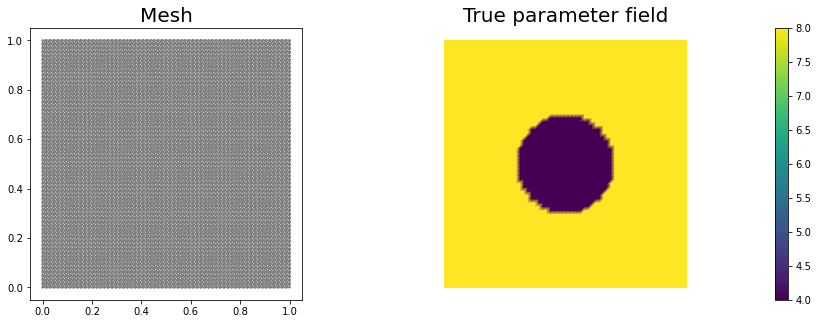

In [2]:
# create mesh and define function spaces
nx = 64
ny = 64
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and initial guess inverted parameter
mtrue = dl.interpolate(dl.Expression('8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
f = dl.interpolate(dl.Expression('std::max(0.5, exp(-25*(x[0]-0.7)*(x[0]-0.7) - 25 * (x[1]-0.7)*(x[1]-0.7)))', degree=2), Vu)
v  = dl.Constant((1.0, 0.0))#advective velocity vector
u0 = dl.Constant(0.0)       #BC
k  = dl.Constant(1.0)       #Diffusion parameter

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh,subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue,subplot_loc=122, mytitle="True parameter field")
plt.show()

In [3]:
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary

bc_state = dl.DirichletBC(Vu, u0, boundary)
bc_adj = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

### Set up synthetic observations:

- Propose a coefficient field $m_{\rm true}$ shown above
- The weak form of the PDE:

    Find $u\in \mathcal{V}$ such that 
    $$\underbrace{(e^{m_{\rm true}}\nabla u,\nabla v)}_{\; := \; a_{\rm true}} - \underbrace{(f,v)}_{\; := \;L_{\rm true}} = 0, \text{ for all } v\in \mathcal{V}.$$

- Perturb the solution: $u = u + \eta$, where $\eta \sim \mathcal{N}(0, \sigma^2)$

### The cost function evaluation:

$$
J(m):=\underbrace{\frac{1}{2}\int_\Omega (u-u_d)^2\, dx}_{\text{misfit} } + \underbrace{\frac{\gamma}{2}\int_\Omega|\nabla m|^2\,dx}_{\text{reg}}
$$

### Setting up the variational form for the state/adjoint equations and gradient evaluation

Below we define the variational forms that appear in the state/adjoint equations and gradient evaluations.

Specifically,

- `a_state`, `L_state` stand for the bilinear and linear forms of the state equation, repectively;
- `a_adj`, `L_adj` stand for the bilinear and linear forms of the adjoint equation, repectively;
- `CTvarf`, `gradRvarf` stand for the contributions to the gradient coming from the PDE and the regularization, respectively.

We also build the *mass* matrix $M$ that is used to discretize the $L^2(\Omega)$ inner product.

### Variational forms for Hessian action

We define the following variational forms that are needed for the Hessian evaluation

- `W_varf`, `R_varf` are the second variations of the data-misfit and regularization component of the cost functional respectively (note since `W_varf`, `R_varf` are independent of $u$, $m$, $p$ they can be preassembled);

- `C_varf` is the second variation of the PDE with respect to $p$ and $m$;

- `Wum_varf` is the second variation of the PDE with respect to $u$ and $m$;

- `Wmm_varf` is the second variation of the PDE with respect to $m$.

> **Note**: Since the forward problem is linear, the bilinear forms for the incremental state and adjoint equations are the same as the bilinear forms for the state and adjoint equations, respectively.

### Hessian action on a vector $\bhm$:

Here we describe how to apply the Hessian operator to a vector $\bhm$. For an opportune choice of the regularization, the Hessian operator evaluated in a neighborhood of the solution is positive define, whereas far from the solution the reduced Hessian may be indefinite. On the contrary, the Gauss-Newton approximation of the Hessian is always positive defined.

For this reason, it is beneficial to perform a few initial Gauss-Newton steps (5 in this particular example) to accelerate the convergence of the inexact Newton-CG algorithm.

The Hessian action reads:
$$
\begin{align}
\bhu &= -\bA^{-1} \bC \bhm\, & \text{incremental forward}\\
\bhp &= -\bA^{-T} (\bW_{\scriptsize\mbox{uu}} \bhu +
\bW_{\scriptsize\mbox{um}}\,\bhm) & \text{incremental adjoint}\\
\bH \bhm &= (\bR + \bW_{\scriptsize\mbox{mm}})\bhm + \bC^T \bhp + \bW_{\scriptsize\mbox{mu}} \bhu.
\end{align}
$$

The Gauss-Newton Hessian action is obtained by dropping the second derivatives operators $\bW_{\scriptsize\mbox{um}}\,\bhm$, $\bW_{\scriptsize\mbox{mm}}\bf \bhm$, and $\bW_{\scriptsize\mbox{mu}} \bhu$:
$$
\begin{align}
\bhu &= -\bA^{-1} \bC \bf \bhm\, & \text{incremental forward}\\
\bhp &= -\bA^{-T} \bW_{\scriptsize\mbox{uu}} \bhu & \text{incremental adjoint}\\
\bH_{\rm GN} \bhm &= \bR \bhm + \bC^T \bhp.
\end{align}
$$



In [4]:
# Class HessianOperator to perform Hessian apply to a vector
class HessianOperator():
    cgiter = 0
    def __init__(self, R, Wmm, C, A, adj_A, W, Wum, bc0, use_gaussnewton=False):
        self.R = R
        self.Wmm = Wmm
        self.C = C
        self.A = A
        self.adj_A = adj_A
        self.W = W
        self.Wum = Wum
        self.bc0 = bc0
        self.use_gaussnewton = use_gaussnewton
        
        # incremental state
        self.du = dl.Vector()
        self.A.init_vector(self.du,0)
        
        #incremental adjoint
        self.dp = dl.Vector()
        self.adj_A.init_vector(self.dp,0)
        
        # auxiliary vector
        self.Wum_du = dl.Vector()
        self.Wum.init_vector(self.Wum_du, 1)
        
    def init_vector(self, v, dim):
        self.R.init_vector(v,dim)

    # Hessian performed on v, output as generic vector y
    def mult(self, v, y):
        self.cgiter += 1
        y.zero()
        if self.use_gaussnewton:
            self.mult_GaussNewton(v,y)
        else:
            self.mult_Newton(v,y)
            
    # define (Gauss-Newton) Hessian apply H * v
    def mult_GaussNewton(self, v, y):
        
        #incremental forward
        rhs = -(self.C * v)
        self.bc0.apply(rhs)
        dl.solve (self.A, self.du, rhs)
        
        #incremental adjoint
        rhs = - (self.W * self.du)
        self.bc0.apply(rhs)
        dl.solve (self.adj_A, self.dp, rhs)
                
        # Misfit term
        self.C.transpmult(self.dp, y)
        
        if self.R:
            Rv = self.R*v
            y.axpy(1, Rv)
        
    # define (Newton) Hessian apply H * v
    def mult_Newton(self, v, y):
        
        #incremental forward
        rhs = -(self.C * v)
        self.bc0.apply(rhs)
        dl.solve (self.A, self.du, rhs)
        
        #incremental adjoint
        rhs = -(self.W * self.du) -  self.Wum * v
        self.bc0.apply(rhs)
        dl.solve (self.adj_A, self.dp, rhs)
                
        #Misfit term
        self.C.transpmult(self.dp, y)
        
        self.Wum.transpmult(self.du, self.Wum_du)
        y.axpy(1., self.Wum_du)
        
        y.axpy(1., self.Wmm*v)
        
        #Reg/Prior term
        if self.R:
            y.axpy(1., self.R*v)
        

In [5]:
def AddDiffInverseProblem(nx, ny, gamma, v, morozov = False, plot = True, noise_level=0.01, useTV=False):
    np.random.seed(seed=1)
    mesh = dl.UnitSquareMesh(nx, ny)
    Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
    Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

    # The true and initial guess inverted parameter
    mtrue = dl.interpolate(dl.Expression('8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) )', degree=5), Vm)

    # define function for state and adjoint
    u = dl.Function(Vu)
    m = dl.Function(Vm)
    p = dl.Function(Vu)

    # define Trial and Test Functions
    u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
    u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

    # initialize input functions
    f = dl.interpolate(dl.Expression('std::max(0.5, exp(-25*(x[0]-0.7)*(x[0]-0.7) - 25 * (x[1]-0.7)*(x[1]-0.7)))', degree=2), Vu)

    v = dl.Constant((1.0, 0.0))

    k = dl.Constant(1.0)

    u0 = dl.Constant(0.0)    
    
    # set up dirichlet boundary conditions
    def boundary(x,on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vu, u0, boundary)
    bc_adj = dl.DirichletBC(Vu, dl.Constant(0.), boundary)
    
    # noise level
    #noise_level = 0.01

    # weak form for setting up the synthetic observations
    #a_true = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
    #         dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
    #         dl.inner(dl.Constant(300) * dl.exp(m)  * u * u * u_trial, p_test) * dl.dx
    

    #L_true = dl.inner(dl.Constant(100) * m_trial * dl.exp(m) * u * u * u, p_test) * dl.dx

    
    a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx \
            + dl.dot(v, dl.grad(u_trial))*u_test*dl.dx
    L_true = f * u_test * dl.dx
    A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

    utrue = dl.Function(Vu)
    
    F = k*dl.inner(dl.grad(utrue), dl.grad(u_test)) * dl.dx + \
    dl.inner(v, dl.grad(utrue)) * u_test * dl.dx + \
    100*dl.exp(mtrue)*utrue*utrue*utrue*u_test * dl.dx - \
    f*u_test*dl.dx
    
    dl.solve(F == 0, utrue, bc_state, solver_parameters={"newton_solver": \
                                                     {"relative_tolerance": 1e-6}})    

    ud = dl.Function(Vu)
    ud.assign(utrue)

    # perturb state solution and create synthetic measurements ud
    # ud = u + ||u||/SNR * random.normal
    MAX = ud.vector().norm("linf")
    noise = dl.Vector()
    A_true.init_vector(noise,1)
    noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
    bc_adj.apply(noise)

    ud.vector().axpy(1., noise)
    
    # define cost function
    def cost(u, ud, m,gamma):
        if useTV:
            reg = gamma * dl.assemble( dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps)*dl.dx ) 
        else:
            reg = 0.5* gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
            
        misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
        return [reg + misfit, misfit, reg]
    
    # weak form for setting up the state equation
    
    F_state = dl.inner(k * dl.grad(u) , dl.grad(p_test)) * dl.dx + \
          dl.dot(v, dl.grad(u)) * p_test * dl.dx + \
          dl.Constant(100)*dl.exp(m) * u**3 * p_test * dl.dx - \
          f * p_test * dl.dx

    # weak form for gradient
    CTvarf = dl.inner(dl.Constant(100) * m_trial* dl.exp(m) * u**3, p_test) * dl.dx 
    gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

    # L^2 weighted inner product
    M_varf   = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(M_varf)    
    
    # weak form for setting up the adjoint equation
    
    F_adj = (u - ud) * u_test * dl.dx + k * dl.inner(dl.grad(u_test), dl.grad(p)) * dl.dx + \
    dl.dot(v, dl.grad(u_test)) * p * dl.dx + dl.Constant(300) * dl.exp(m) * u * u * u_test * p * dl.dx

    
    # weak form for gradient
    
    CTvarf = dl.Constant(100) * m_test * dl.exp(m) * u**3 * p * dl.dx
    if useTV:
        gradRvarf = ( dl.Constant(gamma)/dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps) )* \
                     dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx
    else:
        gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx    
    
    # L^2 weighted inner product
    M_varf   = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(M_varf)
    
    m0 = dl.interpolate(dl.Constant(4.), Vm )
    m.assign(m0)

    # solve state equation
    dl.solve(F_state == 0, u, bc_state, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
    
    uk = dl.Function(Vu)
    #pk = dl.Function(Vu)

    #dl.solve(F_adj == 0, p, bc_adj, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
    
    '''
    
    dl.solve (state_A, u.vector(), state_b)
    '''
    
    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)
    
    #Hessian varfs
    W_varf   = dl.inner(u_trial, u_test) * dl.dx
    R_varf   = dl.Constant(gamma) * dl.inner(dl.grad(m_trial), dl.grad(m_test)) * dl.dx

    #C_varf   = dl.inner(dl.Constant(100) * dl.exp(m) * m_trial * u**3, u_test) * dl.dx
    C_varf = dl.inner(dl.Constant(100) * m_trial* dl.exp(m) * u**3, p_test) * dl.dx 
    Wum_varf = dl.inner(dl.Constant(300) * dl.exp(m) * m_trial * u * u * u_test, p) * dl.dx
    Wmm_varf = dl.inner(dl.Constant(100) * dl.exp(m) * m_trial * m_test *  u**3,  p) * dl.dx

    a_adj = dl.inner(k * dl.grad(u_test), dl.grad(p_trial)) * dl.dx + \
            dl.inner(dl.dot(v, dl.grad(u_test)), p_trial) * dl.dx + \
            dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_test, p_trial) * dl.dx


    a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx
    #          dl.inner(dl.Constant(100) * m_trial * dl.exp(m) * u * u * u, u_test) * dl.dx

    #L_state = dl.Constant(0.) * u_test * dl.dx


    
    # Assemble constant matrices
    W = dl.assemble(W_varf)
    R = dl.assemble(R_varf)
    
    # define parameters for the optimization
    tol = 1e-8
    c = 1e-4
    maxiter = 12

    # initialize iter counters
    iter = 1
    total_cg_iter = 0
    converged = False

    # initializations
    g, m_delta = dl.Vector(), dl.Vector()
    R.init_vector(m_delta,0)
    R.init_vector(g,0)

    m_prev = dl.Function(Vm)

    print( "Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg" )

    while iter <  maxiter and not converged:

        # solve the adoint problem
        
        dl.solve(F_adj == 0, p, bc_adj, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
        
        #state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
        a_adj = dl.inner(k * dl.grad(u_test), dl.grad(p_trial)) * dl.dx + \
            dl.inner(dl.dot(v, dl.grad(u_test)), p_trial) * dl.dx + \
            dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_test, p_trial) * dl.dx
        
        
        adjoint_A , _= dl.assemble_system(a_adj, dl.Constant(0.) * p_test * dl.dx, bc_adj)
        
        a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx

        
        state_A , _= dl.assemble_system(a_state, dl.Constant(0.) * u_test * dl.dx, bc_state)
        #state_A = dl.assemble(a_state)
        
        #adjoint_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
        #dl.solve(adjoint_A, p.vector(), adjoint_RHS)
        
        # evaluate the  gradient
        MG = dl.assemble(CTvarf + gradRvarf)

        # calculate the L^2 norm of the gradient
        dl.solve(M, g, MG)
        grad2 = g.inner(MG)
        gradnorm = np.sqrt(grad2)

        # set the CG tolerance (use Eisenstat–Walker termination criterion)
        if iter == 1:
            gradnorm_ini = gradnorm
        tolcg = min(0.5, np.sqrt(gradnorm/gradnorm_ini))
    
        # assemble W_um and W_mm
        C   = dl.assemble(C_varf)
        Wum = dl.assemble(Wum_varf)
        Wmm = dl.assemble(Wmm_varf)

        # define the Hessian apply operator (with preconditioner)
        Hess_Apply = HessianOperator(R, Wmm, C, state_A, adjoint_A, W, Wum, bc_adj, use_gaussnewton=(iter<6) )
        P = R + 0.1*gamma * M
        Psolver = dl.PETScKrylovSolver("cg", amg_method())
        Psolver.set_operator(P)
    
        solver = CGSolverSteihaug()
        solver.set_operator(Hess_Apply)
        solver.set_preconditioner(Psolver)
        solver.parameters["rel_tolerance"] = tolcg
        solver.parameters["zero_initial_guess"] = True
        solver.parameters["print_level"] = -1

        # solve the Newton system H a_delta = - MG
        solver.solve(m_delta, -MG)
        total_cg_iter += Hess_Apply.cgiter
    
        # linesearch
        alpha = 1
        descent = 0
        no_backtrack = 0
        m_prev.assign(m)
        while descent == 0 and no_backtrack < 10:
            m.vector().axpy(alpha, m_delta )

            # solve the state/forward problem
            dl.solve(F_state == 0, u, bc_state, solver_parameters={"newton_solver": {"relative_tolerance": 1e-5}})
            a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx
    
            
            state_A = dl.assemble(a_state)
            
            #state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
            #dl.solve(state_A, u.vector(), state_b)
            
            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old + alpha * c * MG.inner(m_delta):
                cost_old = cost_new
                descent = 1
            else:
                no_backtrack += 1
                alpha *= 0.5
                m.assign(m_prev)  # reset a

        # calculate sqrt(-G * D)
        graddir = np.sqrt(- MG.inner(m_delta) )

        sp = ""
        print( "%2d %2s %2d %3s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %5.2f %1s %5.3e" % \
            (iter, sp, Hess_Apply.cgiter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
             graddir, sp, gradnorm, sp, alpha, sp, tolcg) )

        # check for convergence
        if gradnorm < tol and iter > 1:
            converged = True
            print( "Newton's method converged in ",iter,"  iterations" )
            print( "Total number of CG iterations: ", total_cg_iter )
        
        iter += 1
    
    if not converged:
        print( "Newton's method did not converge in ", maxiter, " iterations" )
    
    if plot:
        nb.multi1_plot([mtrue, m], ["mtrue", "m"])
        plt.show()
    
    Mstate = dl.assemble(u_trial*u_test*dl.dx)
    noise_norm2 = noise.inner(Mstate*noise)

    if not morozov:
        Hmisfit = HessianOperator(None, Wmm, C, state_A, adjoint_A, W, Wum, bc_adj, use_gaussnewton=True)
        k = 50
        p = 20

        Omega = MultiVector(m.vector(), k+p)
        parRandom.normal(1., Omega)
        lmbda, evecs = doublePassG(Hmisfit, P, Psolver, Omega, k)

        plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
        plt.yscale('log')
        plt.xlabel('number')
        plt.ylabel('eigenvalue')
        plt.show()

        nb.plot_eigenvectors(Vm, evecs, mytitle="Eigenvector", which=[0,1,2,5,10,15])
        plt.show()

        
    
    return Vm.dim(), iter, total_cg_iter, noise_norm2, cost_new, misfit_new, reg_new

We find the optimal value of the regularization parameter using Morozov's discrepancy principle.

****** Computing solution with gamma =  1e-07 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40043e-06   2.40011e-06   3.17859e-10   8.35779e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87596e-07   8.87394e-07   2.01775e-10   1.71777e-03   6.61722e-06    1.00   4.753e-01
 3     2     6.40774e-07   4.93711e-07   1.47063e-07   7.08506e-04   2.47713e-06    1.00   2.908e-01
 4     2     6.23460e-07   4.75595e-07   1.47865e-07   1.85464e-04   6.29992e-07    1.00   1.466e-01
 5     3     6.22202e-07   4.53490e-07   1.68712e-07   4.99122e-05   1.74728e-07    1.00   7.723e-02
 6     5     6.22188e-07   4.54203e-07   1.67985e-07   5.35451e-06   2.86138e-08    1.00   3.125e-02
 7     5     6.22188e-07   4.54175e-07   1.68012e-07   1.13723e-07   4.85920e-10    1.00   4.073e-03
Newton's method converged in  7   iterations
Total number of CG iterations:  19


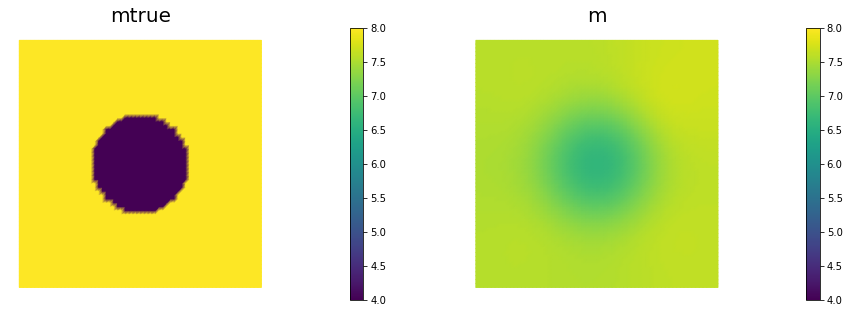

****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40026e-06   2.40023e-06   3.17864e-11   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87438e-07   8.87418e-07   2.02721e-11   1.71776e-03   6.57852e-06    1.00   4.739e-01
 3     4     2.58000e-07   1.29821e-07   1.28179e-07   1.17692e-03   2.45624e-06    1.00   2.896e-01
 4     1     2.22724e-07   9.45056e-08   1.28218e-07   2.65630e-04   9.53987e-07    1.00   1.805e-01
 5     8     2.17274e-07   8.84267e-08   1.28847e-07   1.06269e-04   2.18875e-07    1.00   8.644e-02
 6     5     2.17229e-07   8.88363e-08   1.28392e-07   9.52830e-06   2.05604e-08    1.00   2.649e-02
 7    11     2.17227e-07   8.87431e-08   1.28484e-07   1.54419e-06   3.82498e-09    1.00   1.143e-02
Newton's method converged in  7   iterations
Total number of CG iterations:  31


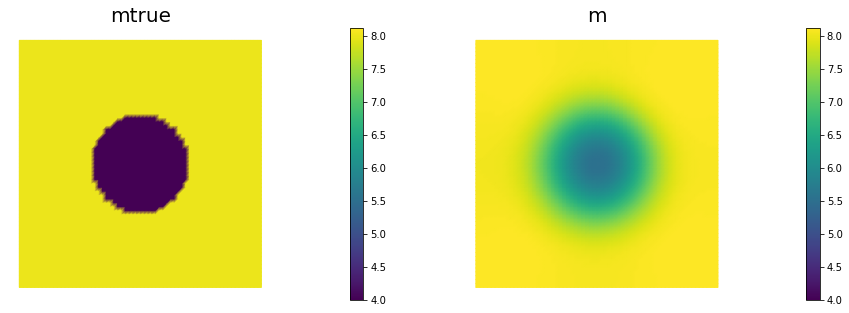

****** Computing solution with gamma =  1e-09 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40025e-06   2.40025e-06   3.17864e-12   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87422e-07   8.87420e-07   2.02816e-12   1.71776e-03   6.57466e-06    1.00   4.738e-01
 3     4     1.57640e-07   1.38912e-07   1.87278e-08   1.28998e-03   2.45417e-06    1.00   2.894e-01
 4     1     8.16579e-08   6.29227e-08   1.87352e-08   3.90046e-04   1.32922e-06    1.00   2.130e-01
 5    10     5.67562e-08   2.60760e-08   3.06802e-08   2.36372e-04   3.08177e-07    1.00   1.026e-01
 6     1     5.56556e-08   2.49750e-08   3.06806e-08   4.71613e-05   1.73272e-07    1.00   7.691e-02
 7    18     5.44608e-08   2.32601e-08   3.12008e-08   4.89628e-05   5.74841e-08    1.00   4.430e-02
 8     1     5.44574e-08   2.32566e-08   3.12008e-08   2.62863e-06   1.07642e-08    1.00   1.917e-02
 9    32     5.44499e-08   2.33249e-08   3

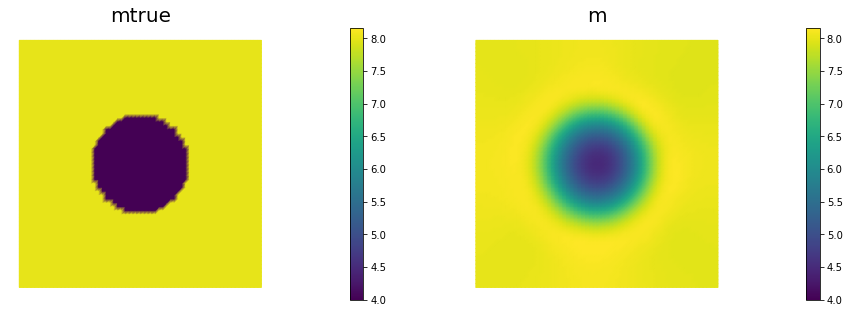

****** Computing solution with gamma =  1e-10 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17743e-13   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87410e-07   8.87410e-07   2.02753e-13   1.71777e-03   6.57428e-06    1.00   4.737e-01
 3     4     1.46148e-07   1.44195e-07   1.95357e-09   1.30326e-03   2.45394e-06    1.00   2.894e-01
 4     1     6.33682e-08   6.14138e-08   1.95437e-09   4.07134e-04   1.38062e-06    1.00   2.171e-01
 5    15     2.97626e-08   2.53070e-08   4.45568e-09   2.96945e-04   3.29999e-07    1.00   1.061e-01
 6     1     2.18906e-08   1.74348e-08   4.45575e-09   1.27439e-04   4.70462e-07    1.00   1.267e-01
 7    15     1.94352e-08   1.39266e-08   5.50857e-09   6.84750e-05   6.83532e-08    1.00   4.831e-02
 8     1     1.93752e-08   1.38666e-08   5.50858e-09   1.09669e-05   4.51165e-08    1.00   3.924e-02
 9    58     1.89616e-08   1.31136e-08   5

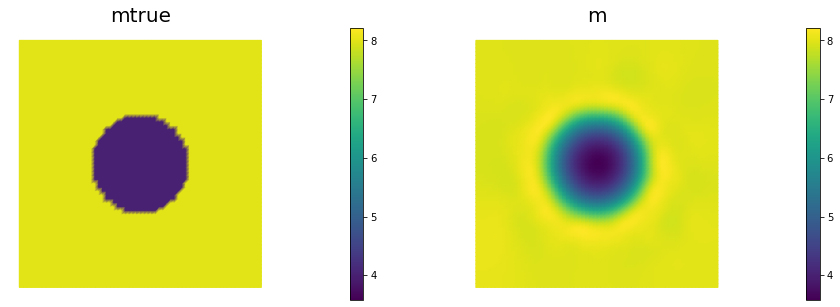

****** Computing solution with gamma =  1e-11 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17742e-14   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87409e-07   8.87409e-07   2.02755e-14   1.71777e-03   6.57424e-06    1.00   4.737e-01
 3     3     1.43043e-07   1.42846e-07   1.96182e-10   1.30445e-03   2.45391e-06    1.00   2.894e-01
 4     1     6.14971e-08   6.13008e-08   1.96262e-10   4.04086e-04   1.37045e-06    1.00   2.163e-01
 5    14     2.71881e-08   2.67214e-08   4.66674e-10   3.04506e-04   3.32372e-07    1.00   1.065e-01
 6     1     1.76460e-08   1.71793e-08   4.66681e-10   1.40558e-04   5.18053e-07    1.00   1.330e-01
 7    14     1.40935e-08   1.34686e-08   6.24830e-10   8.11226e-05   7.83342e-08    1.00   5.171e-02
 8     1     1.39398e-08   1.33150e-08   6.24831e-10   1.75661e-05   7.02408e-08    1.00   4.897e-02
 9    152     1.38516e-08   1.31655e-08   

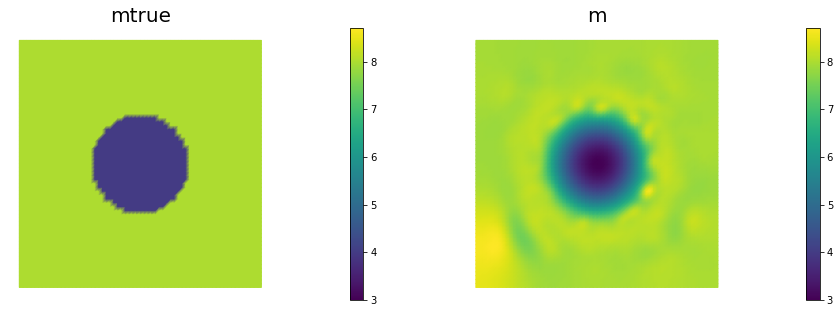

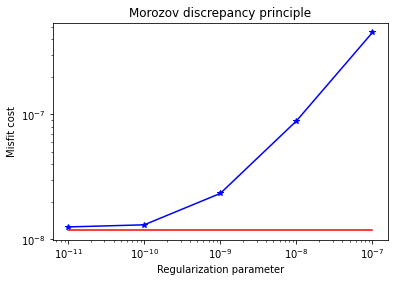

In [6]:
n = 20
gammas = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)
    misfits.append(misfit)
    
plt.loglog(gammas, misfits, "-*b", label="Misfit")
plt.loglog([gammas[0],gammas[-1]], [.5*noise_norm2, .5*noise_norm2], "-r", label="Squared norm noise")
plt.title("Morozov discrepancy principle")
plt.xlabel("Regularization parameter")
plt.ylabel("Misfit cost")
plt.show()



****** Computing solution with gamma =  1e-07 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40043e-06   2.40011e-06   3.17859e-10   8.35779e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87596e-07   8.87394e-07   2.01775e-10   1.71777e-03   6.61722e-06    1.00   4.753e-01
 3     2     6.40774e-07   4.93711e-07   1.47063e-07   7.08506e-04   2.47713e-06    1.00   2.908e-01
 4     2     6.23460e-07   4.75595e-07   1.47865e-07   1.85464e-04   6.29992e-07    1.00   1.466e-01
 5     3     6.22202e-07   4.53490e-07   1.68712e-07   4.99122e-05   1.74728e-07    1.00   7.723e-02
 6     5     6.22188e-07   4.54203e-07   1.67985e-07   5.35451e-06   2.86138e-08    1.00   3.125e-02
 7     5     6.22188e-07   4.54175e-07   1.68012e-07   1.13723e-07   4.85920e-10    1.00   4.073e-03
Newton's method converged in  7   iterations
Total number of CG iterations:  19


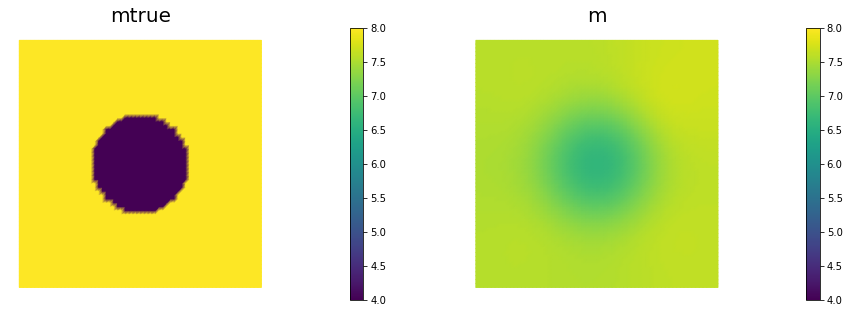

****** Computing solution with gamma =  1e-08 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40026e-06   2.40023e-06   3.17864e-11   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87438e-07   8.87418e-07   2.02721e-11   1.71776e-03   6.57852e-06    1.00   4.739e-01
 3     4     2.58000e-07   1.29821e-07   1.28179e-07   1.17692e-03   2.45624e-06    1.00   2.896e-01
 4     1     2.22724e-07   9.45056e-08   1.28218e-07   2.65630e-04   9.53987e-07    1.00   1.805e-01
 5     8     2.17274e-07   8.84267e-08   1.28847e-07   1.06269e-04   2.18875e-07    1.00   8.644e-02
 6     5     2.17229e-07   8.88363e-08   1.28392e-07   9.52830e-06   2.05604e-08    1.00   2.649e-02
 7    11     2.17227e-07   8.87431e-08   1.28484e-07   1.54419e-06   3.82498e-09    1.00   1.143e-02
Newton's method converged in  7   iterations
Total number of CG iterations:  31


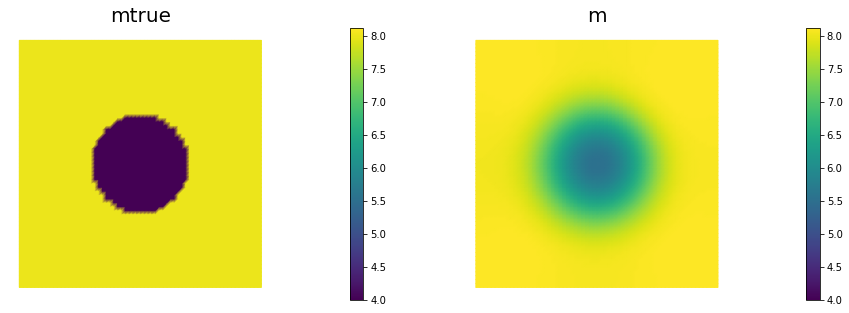

****** Computing solution with gamma =  1e-09 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40025e-06   2.40025e-06   3.17864e-12   8.35782e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87422e-07   8.87420e-07   2.02816e-12   1.71776e-03   6.57466e-06    1.00   4.738e-01
 3     4     1.57640e-07   1.38912e-07   1.87278e-08   1.28998e-03   2.45417e-06    1.00   2.894e-01
 4     1     8.16579e-08   6.29227e-08   1.87352e-08   3.90046e-04   1.32922e-06    1.00   2.130e-01
 5    10     5.67562e-08   2.60760e-08   3.06802e-08   2.36372e-04   3.08177e-07    1.00   1.026e-01
 6     1     5.56556e-08   2.49750e-08   3.06806e-08   4.71613e-05   1.73272e-07    1.00   7.691e-02
 7    18     5.44608e-08   2.32601e-08   3.12008e-08   4.89628e-05   5.74841e-08    1.00   4.430e-02
 8     1     5.44574e-08   2.32566e-08   3.12008e-08   2.62863e-06   1.07642e-08    1.00   1.917e-02
 9    32     5.44499e-08   2.33249e-08   3

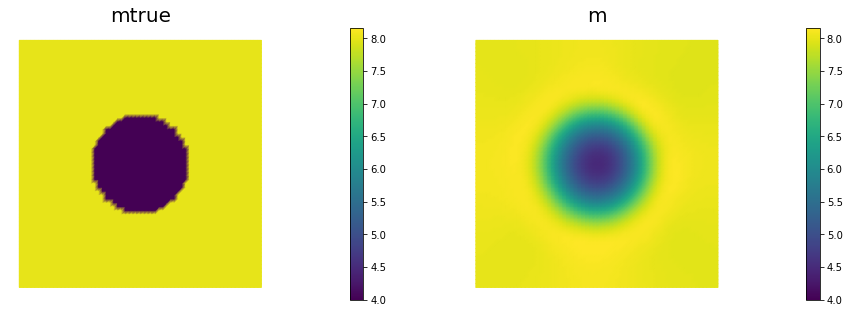

****** Computing solution with gamma =  1e-10 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17743e-13   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87410e-07   8.87410e-07   2.02753e-13   1.71777e-03   6.57428e-06    1.00   4.737e-01
 3     4     1.46148e-07   1.44195e-07   1.95357e-09   1.30326e-03   2.45394e-06    1.00   2.894e-01
 4     1     6.33682e-08   6.14138e-08   1.95437e-09   4.07134e-04   1.38062e-06    1.00   2.171e-01
 5    15     2.97626e-08   2.53070e-08   4.45568e-09   2.96945e-04   3.29999e-07    1.00   1.061e-01
 6     1     2.18906e-08   1.74348e-08   4.45575e-09   1.27439e-04   4.70462e-07    1.00   1.267e-01
 7    15     1.94352e-08   1.39266e-08   5.50857e-09   6.84750e-05   6.83532e-08    1.00   4.831e-02
 8     1     1.93752e-08   1.38666e-08   5.50858e-09   1.09669e-05   4.51165e-08    1.00   3.924e-02
 9    58     1.89616e-08   1.31136e-08   5

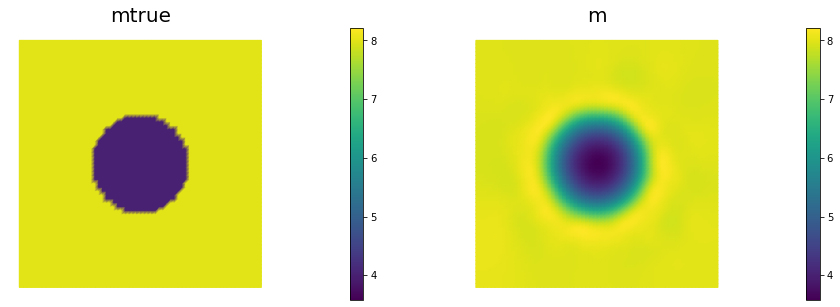

****** Computing solution with gamma =  1e-11 ******
Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40024e-06   2.40024e-06   3.17742e-14   8.35783e-03   2.92937e-05    1.00   5.000e-01
 2     1     8.87409e-07   8.87409e-07   2.02755e-14   1.71777e-03   6.57424e-06    1.00   4.737e-01
 3     3     1.43043e-07   1.42846e-07   1.96182e-10   1.30445e-03   2.45391e-06    1.00   2.894e-01
 4     1     6.14971e-08   6.13008e-08   1.96262e-10   4.04086e-04   1.37045e-06    1.00   2.163e-01
 5    14     2.71881e-08   2.67214e-08   4.66674e-10   3.04506e-04   3.32372e-07    1.00   1.065e-01
 6     1     1.76460e-08   1.71793e-08   4.66681e-10   1.40558e-04   5.18053e-07    1.00   1.330e-01
 7    14     1.40935e-08   1.34686e-08   6.24830e-10   8.11226e-05   7.83342e-08    1.00   5.171e-02
 8     1     1.39398e-08   1.33150e-08   6.24831e-10   1.75661e-05   7.02408e-08    1.00   4.897e-02


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  
*** -------------------------------------------------------------------------


In [7]:
n = 40
gammas = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)
    misfits.append(misfit)
    
plt.loglog(gammas, misfits, "-*b", label="Misfit")
plt.loglog([gammas[0],gammas[-1]], [.5*noise_norm2, .5*noise_norm2], "-r", label="Squared norm noise")
plt.title("Morozov discrepancy principle")
plt.xlabel("Regularization parameter")
plt.ylabel("Misfit cost")
plt.show()



In [ ]:
n = 80
gammas = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(nx, ny, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)
    misfits.append(misfit)
    
plt.loglog(gammas, misfits, "-*b", label="Misfit")
plt.loglog([gammas[0],gammas[-1]], [.5*noise_norm2, .5*noise_norm2], "-r", label="Squared norm noise")
plt.title("Morozov discrepancy principle")
plt.xlabel("Regularization parameter")
plt.ylabel("Misfit cost")
plt.show()



## How does the algorithm behave as we refine the mesh?

We solve the problem with $8 \times 8$, $16 \times 16$, $32 \times 32$, $64 \times 64$ finite elements, and observe the following behavior:

- The number of inexact Newton and of total CG iterations is independent of the resolution of the spacial discretization. This means that inexact Newton-CG method scalable with respect to the parameter dimension, i.e. the cost of solving the inverse problem (measured in terms of number of PDE solves) is independent of the mesh size.

- The dominant generalized eigenvalues and eigenvectors look the same at different spatial resolution. This is a well-studied spectral property of the Hessian misfit.

In [ ]:
ns = [8,16,32,64]
niters = []
ncgiters = []
ndofs  = []

for n in ns:
    ndof, niter, ncgiter, _,_,_,_ = AddDiffInverseProblem(nx=n, ny=n, v=dl.Constant((30., 0.)), gamma = 1e-9)
    niters.append(niter)
    ncgiters.append(ncgiter)
    ndofs.append(ndof)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.semilogx(ndofs, niters)
plt.ylim([0, 12])
plt.xlabel("Parameter dimension")
plt.ylabel("Number of Newton iterations")
plt.subplot(122)
plt.semilogx(ndofs, ncgiters)
plt.ylim([0, 150])
plt.xlabel("Parameter dimension")
plt.ylabel("Number of CG iterations")
plt.show()

Copyright &copy; 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright &copy; 2019, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis. <br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.